In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import pandas as pd

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['axes.titlesize'] = 20

%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# ESPL with Gaussian likelihood


In [2]:
!cat gaussian_model/OPTIONS

#File containing parameters for DNest4
# Put comments at the top, or at the end of the line.
2 # Number of particles per thread
10000   # new level interval
10000   # save interval
100     # threadSteps - how many steps each thread should do independently before communication
0      # maximum number of levels
10      # Backtracking scale length (lambda in the paper)
100     # Strength of effect to force histogram to equal push (beta in the paper)
10000	# Maximum number of saves (0 = infinite)


In [3]:
event = '2017/blg-0055' # '2017/0717'

data = pd.read_csv('../../microlensing_data/OGLE/' + event + '/phot.dat', 
                   names=['HJD', 'I_flux', 'I_flux_err', 'seeing_est', 'sky_level'],
                   delim_whitespace=True)

mag_to_flux = lambda m: 10**(-m/2.5)
magerr_to_fluxerr = lambda m, sigm: sigm*mag_to_flux(m)

data['HJD'] -= 2450000
data['I_flux_err'] = magerr_to_fluxerr(data['I_flux'].values, data['I_flux_err'].values)
data['I_flux'] = mag_to_flux(data['I_flux'].values)

# Normalize flux units
data['I_flux'] = (data['I_flux'] - data['I_flux'].min())/(data['I_flux'].max() - data['I_flux'].min())
data['I_flux_err'] = data['I_flux_err']/(data['I_flux'].max() - data['I_flux'].min())

# Save to .txt file, to be read by DNest4
np.savetxt('lightcurve.txt', data.values[:, :-2])

In [4]:
# Compile DNest4
!cd gaussian_model/
!make clean
!make

make: *** No rule to make target 'clean'. Stop.
make: *** No targets specified and no makefile found. Stop.


In [5]:
# Run DNest4 model on 4 threads
!./main -t 4

# Using 4 threads.
# Target compression factor between levels = 2.7182818284590451
# Seeding random number generators. First seed = 1519395505.
# Generating 8 particles from the prior...done.
# Saving particle to disk. N = 1.
# Saving particle to disk. N = 2.
# Saving particle to disk. N = 3.
# Saving particle to disk. N = 4.
# Saving particle to disk. N = 5.
# Saving particle to disk. N = 6.
# Saving particle to disk. N = 7.
# Saving particle to disk. N = 8.
# Saving particle to disk. N = 9.
# Saving particle to disk. N = 10.
# Saving particle to disk. N = 11.
# Saving particle to disk. N = 12.
# Saving particle to disk. N = 13.
# Saving particle to disk. N = 14.
# Saving particle to disk. N = 15.
# Saving particle to disk. N = 16.
# Saving particle to disk. N = 17.
# Saving particle to disk. N = 18.
# Saving particle to disk. N = 19.
# Saving particle to disk. N = 20.
# Saving particle to disk. N = 21.
# Saving particle to disk. N = 22.
# Saving particle to disk. N = 23.
# Saving par

In [14]:
# Run postprocessing
!python showresults.py

log(Z) = -1807.65958462
Information = 28.4445808527 nats.
Effective sample size = 3575.23074615


In [5]:
# Load the posterior samples
posterior_samples = np.loadtxt('gaussian_model/posterior_sample.txt')

print(posterior_samples.shape)

(1387, 6)


In [8]:
# %cd ../NS_model

/home/fran/drive/projects/PSPL_model/NS_model


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

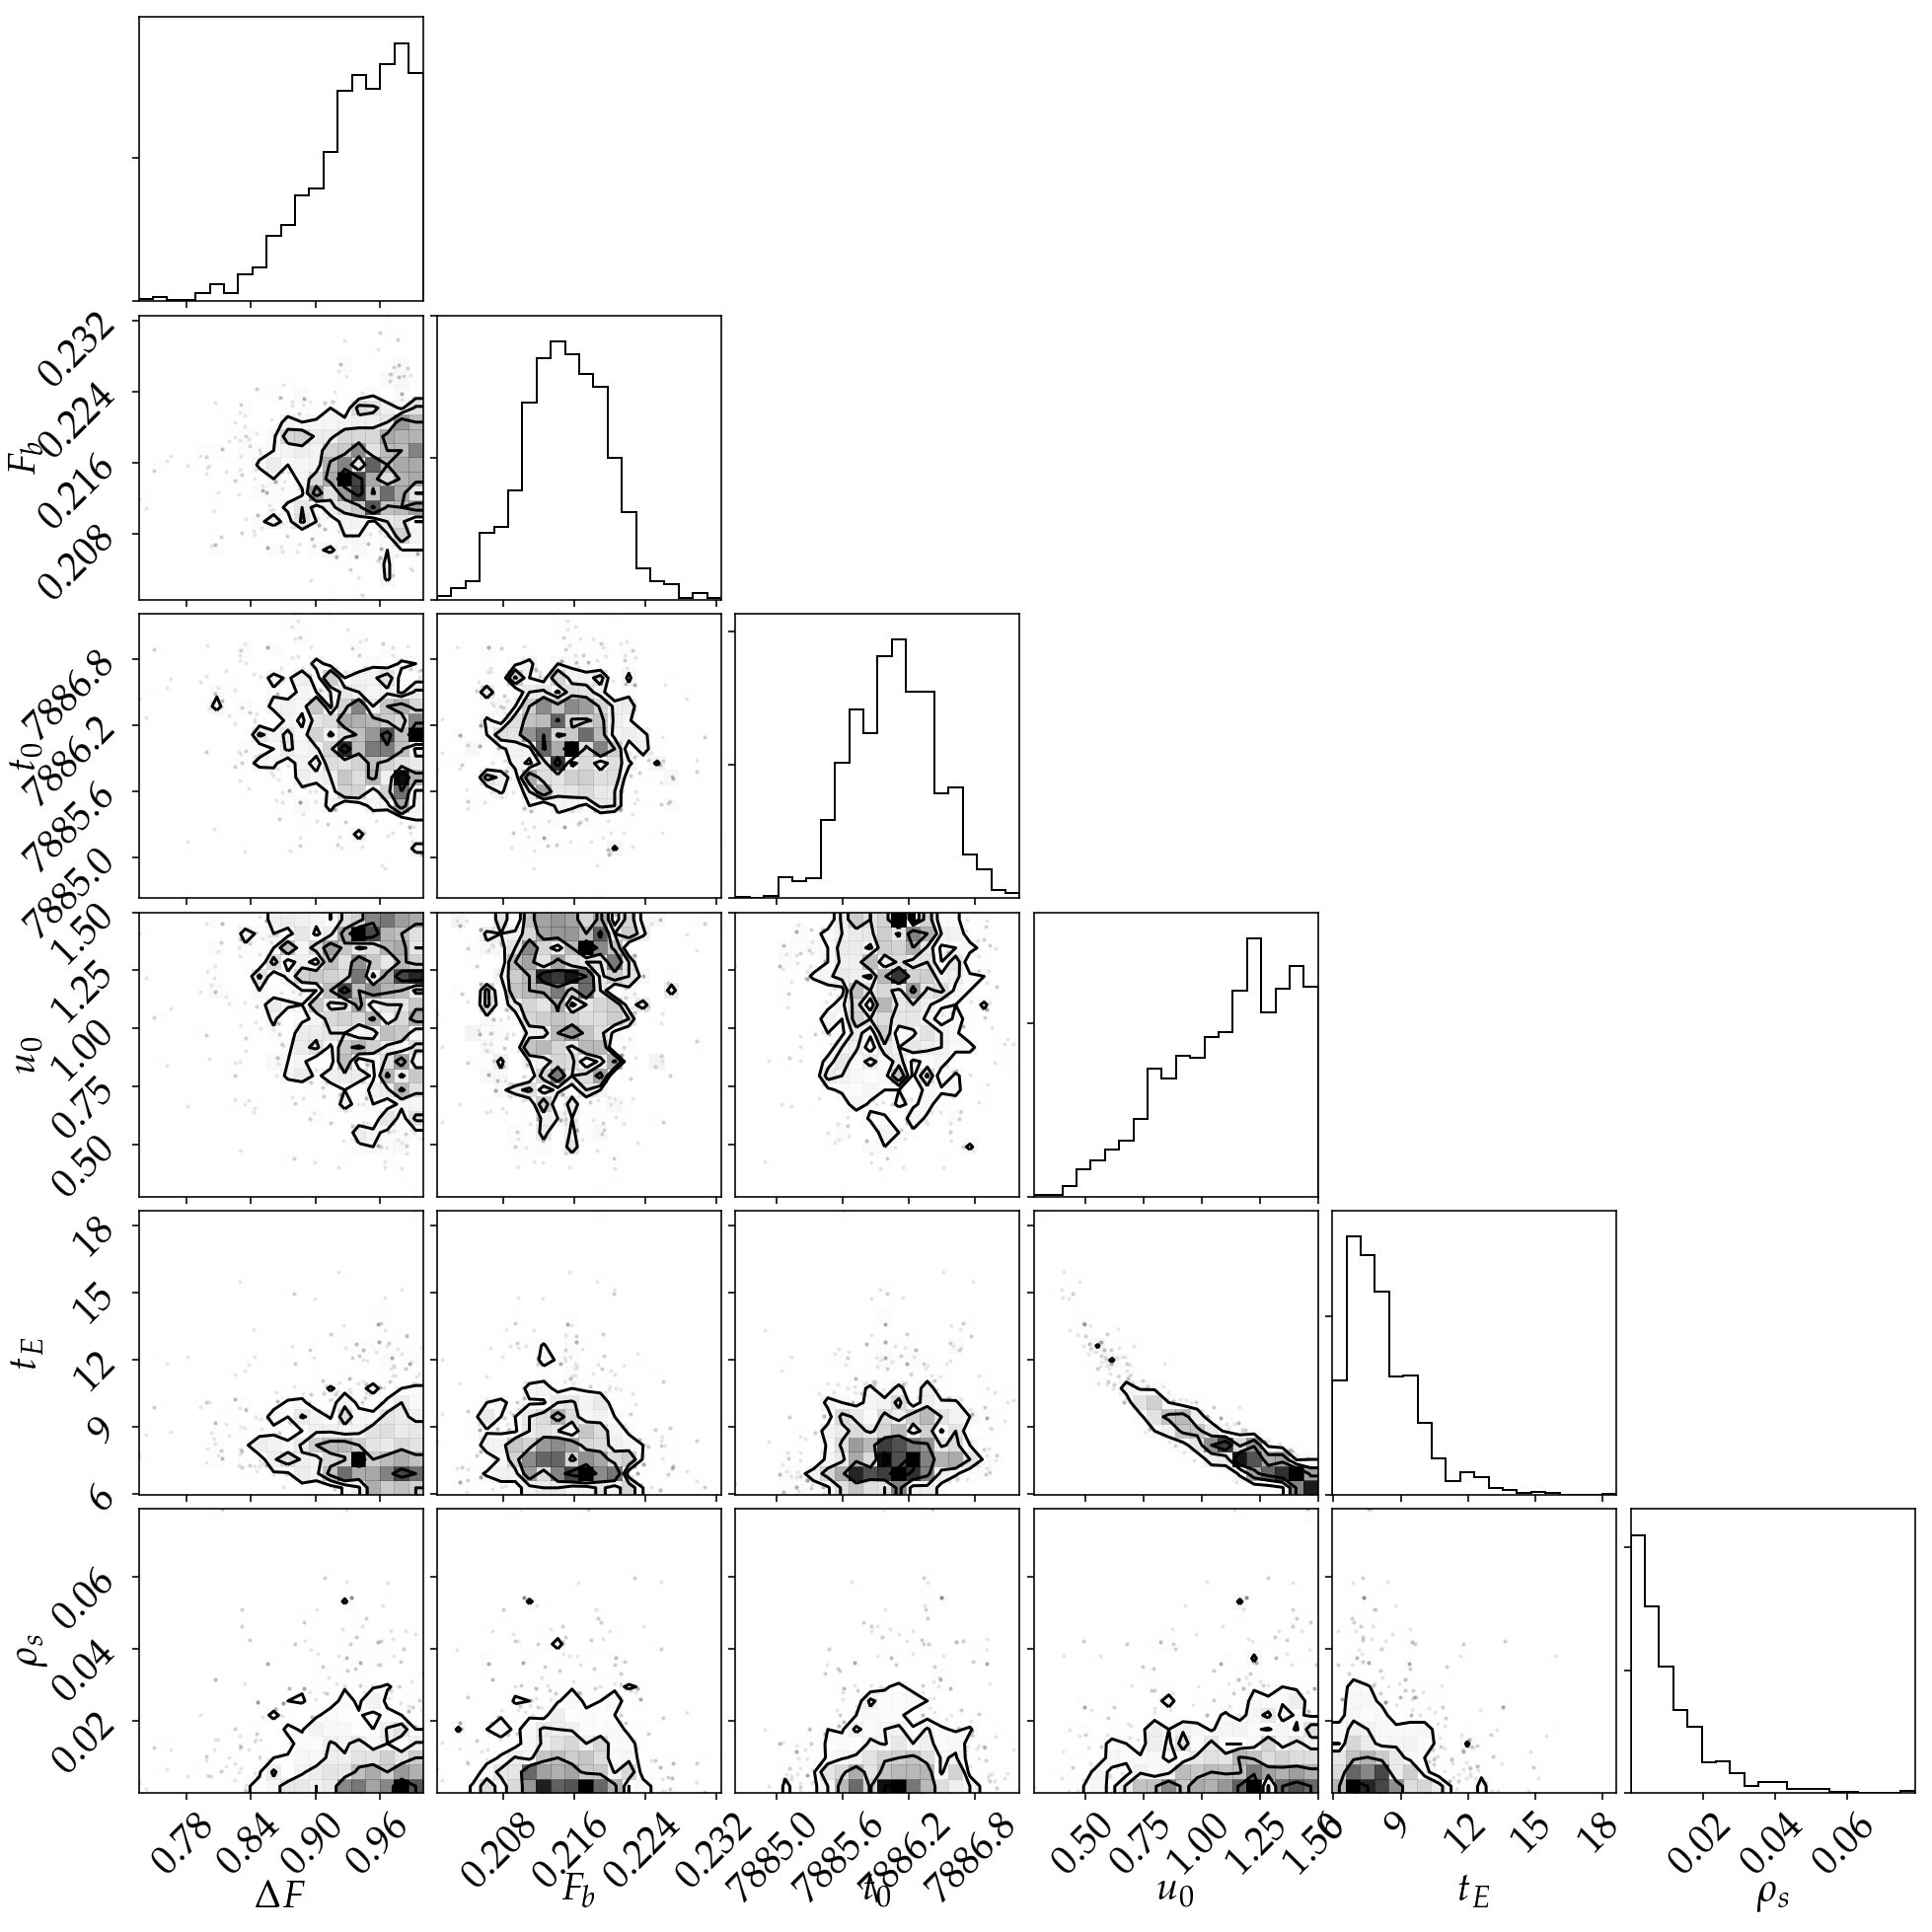

In [6]:
import corner 
from IPython.display import display, Math

lbls = [r'$\Delta F$', r'$F_b$', r'$t_0$', r'$u_0$', r'$t_E$', r'$\rho_s$']
labels = [r'\Delta F', r'F_b', r't_0', r'u_0', r't_E', r'\rho_s']

ndim = 6

for i in range(ndim):
    mcmc = np.percentile(posterior_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    
fig = corner.corner(posterior_samples, labels=lbls)

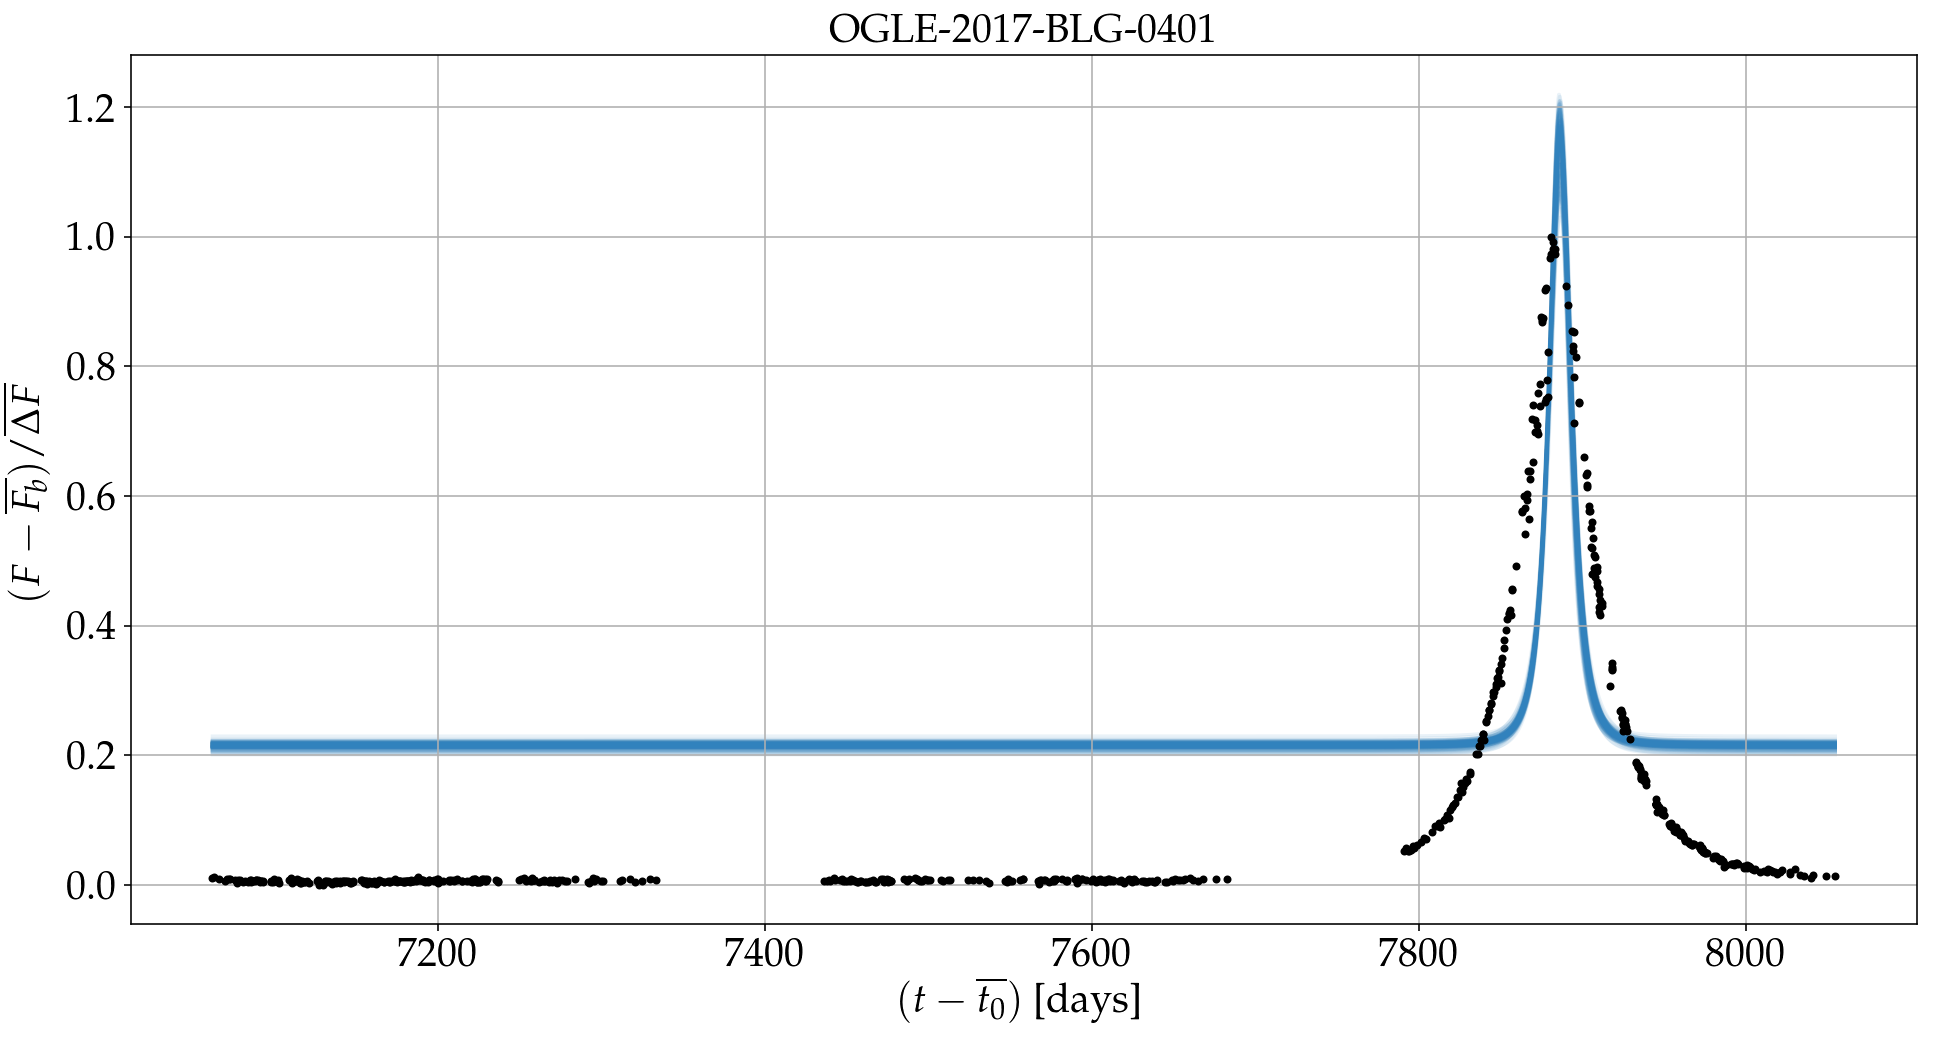

In [14]:
def pspl_flux(t, pars):
        """
        Evaluate a PSPL model at the input t values.


        Parameters
        ----------
        pars : list, array
            This should be a length-5 array or list containing the 
            parameter values (DeltaF, Fb, t0, u0, tE).
        t : numeric, list, array
            The time values.

        Returns
        -------
        F : array
            The computed flux values at each input t.
        """
            
        DeltaF, Fb, t0, u0, tE, rho = pars

        u = np.sqrt(u0**2 + ((t - t0)/tE)**2)
        A = lambda u: (u**2 + 2)/(u*np.sqrt(u**2 + 4))

        return DeltaF*(A(u) - 1)/(A(u0) - 1) + Fb    

def plot_data(ax, t, F, sigF):
    ax.errorbar(t, F, sigF, fmt='.', color='black')
    ax.grid(True)
    ax.set_xlabel('$(t-\overline{t_0})$ [days]')
    ax.set_ylabel('$(F-\overline{F_b})/\overline{\Delta F}$')
    ax.set_title('OGLE-2017-BLG-0401');
    

def plot_model_and_data(ax, t, F, sigF, posterior):
    t0_median = np.percentile(posterior[:, 2], [50])[0]
    Fb_median = np.percentile(posterior[:, 1], [50])[0]
    DeltaF_median = np.percentile(posterior[:, 0], [50])[0]

    x = t 
    y = F

    # Plot data
    plot_data(ax, x, y, sigF)

    # Plot model in data space
    x_ = np.linspace(t[0], t[-1], 2000) 

    for pars in posterior[:128]: # only plot 128 samples
        y_ = pspl_flux(x_, pars) 
        ax.plot(x_, y_,
                 marker='', linestyle='-', color='#3182bd', alpha=0.1, zorder=-10)

#     ax.set_xlim(-100,100)
    
fig, ax = plt.subplots(figsize=(16,8))
plot_model_and_data(ax, data['HJD'].values, data['I_flux'].values, 
                    data['I_flux_err'].values, posterior_samples)